In [5]:
pip install virtualenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 5.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 6.9 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
!virtualenv -p python3.8 py312

created virtual environment CPython3.8.0.final.0-64 in 35529ms
  creator CPython3Posix(dest=/moca/unet/py312, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==25.0.1, setuptools==75.3.0, wheel==0.45.1
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [1]:
!pip uninstall opencv-python opencv-python-headless -y

In [4]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [8]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.4/315.4 kB 6.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 27.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 6.0 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [5]:
pip show opencv-python

Name: opencv-python
Version: 4.11.0.86
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/opencv/opencv-python
Author: 
Author-email: 
License: Apache 2.0
Location: /usr/local/lib/python3.8/dist-packages
Requires: numpy, numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


✅ GPU 활성화 완료!


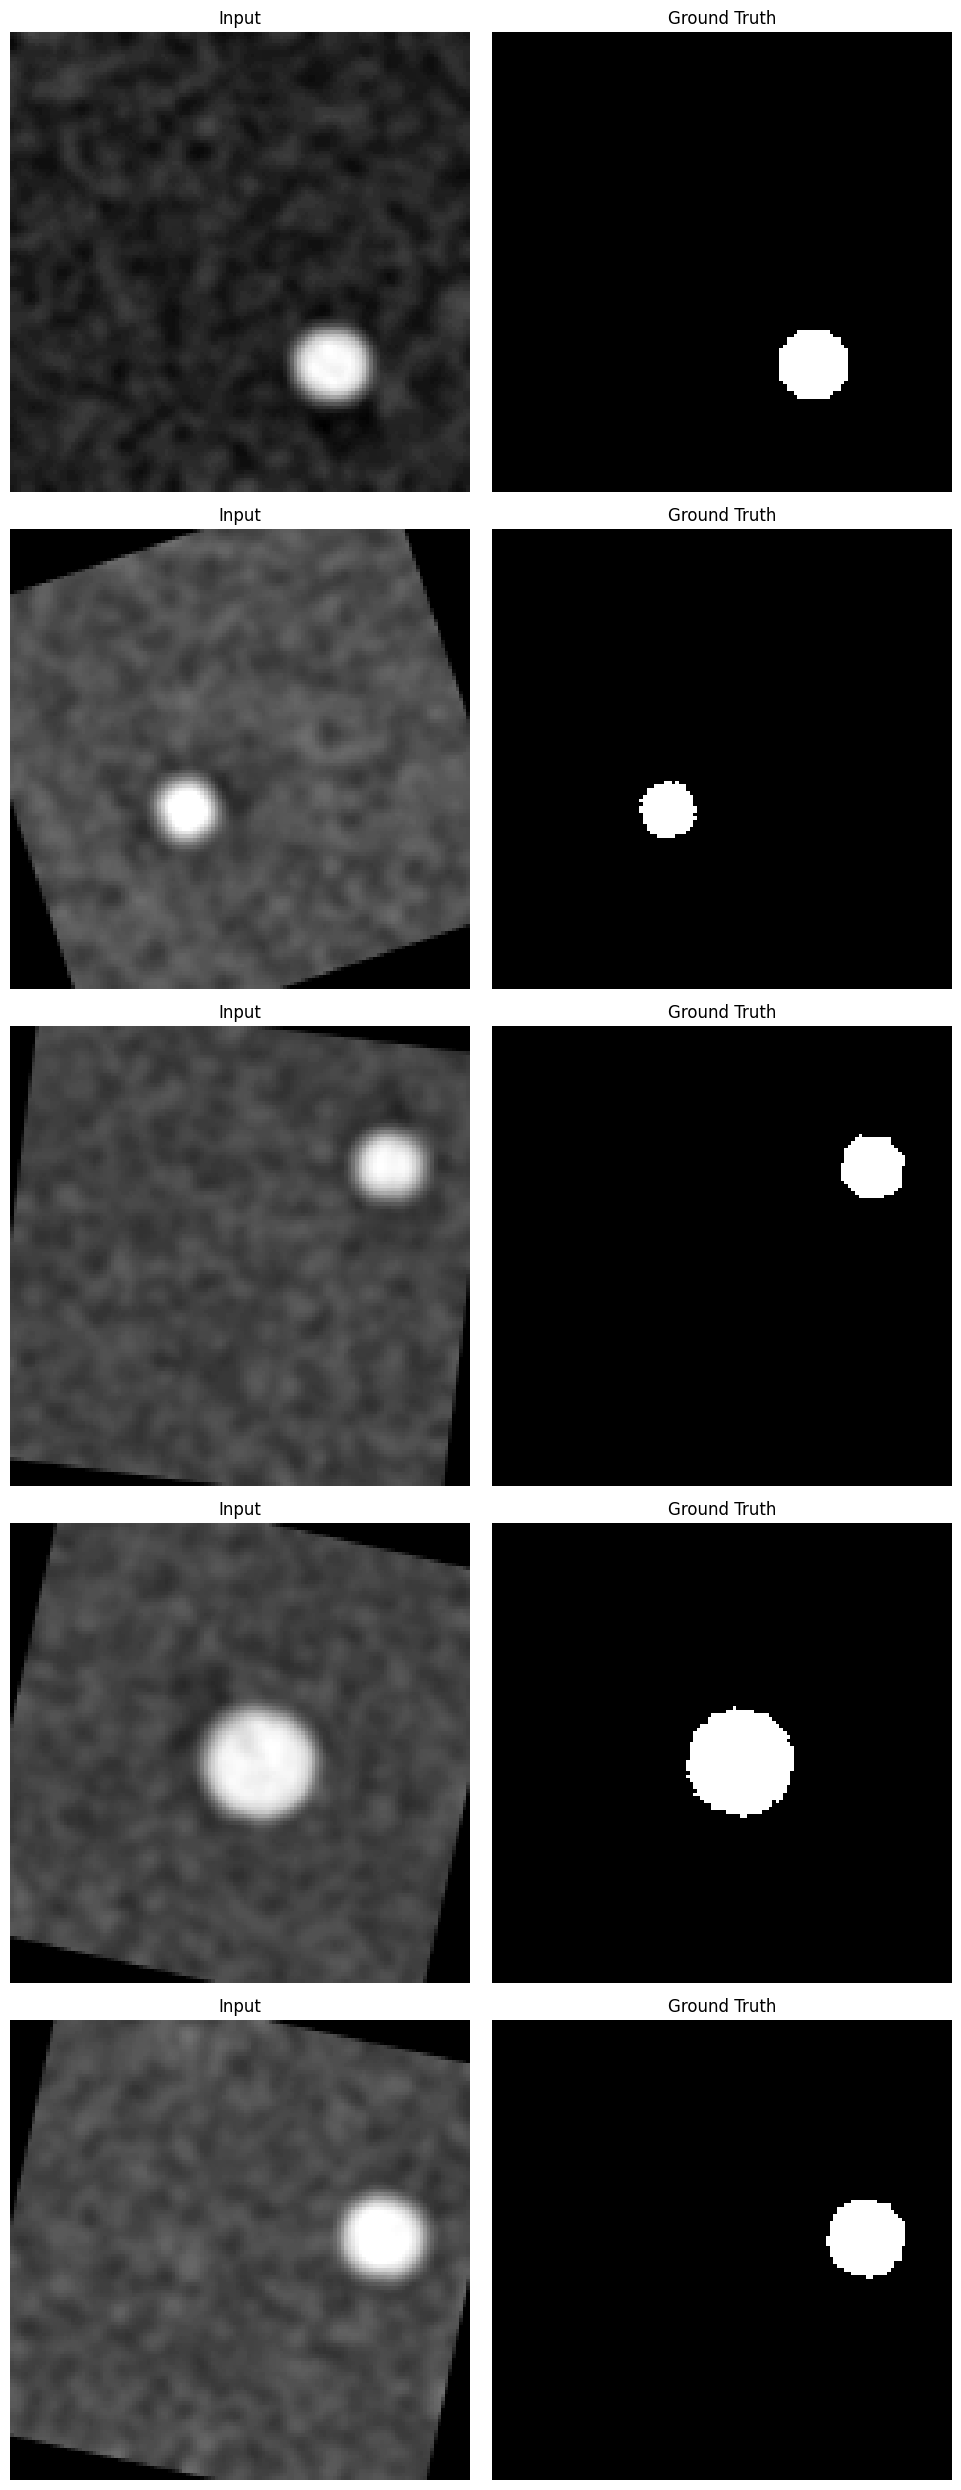

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_243 (Conv2D)         (None, 128, 128, 32)         320       ['input_7[0][0]']             
                                                                                                  
 batch_normalization_117 (B  (None, 128, 128, 32)         128       ['conv2d_243[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_49 (Activation)  (None, 128, 128, 32)         0         ['batch_normalization_11

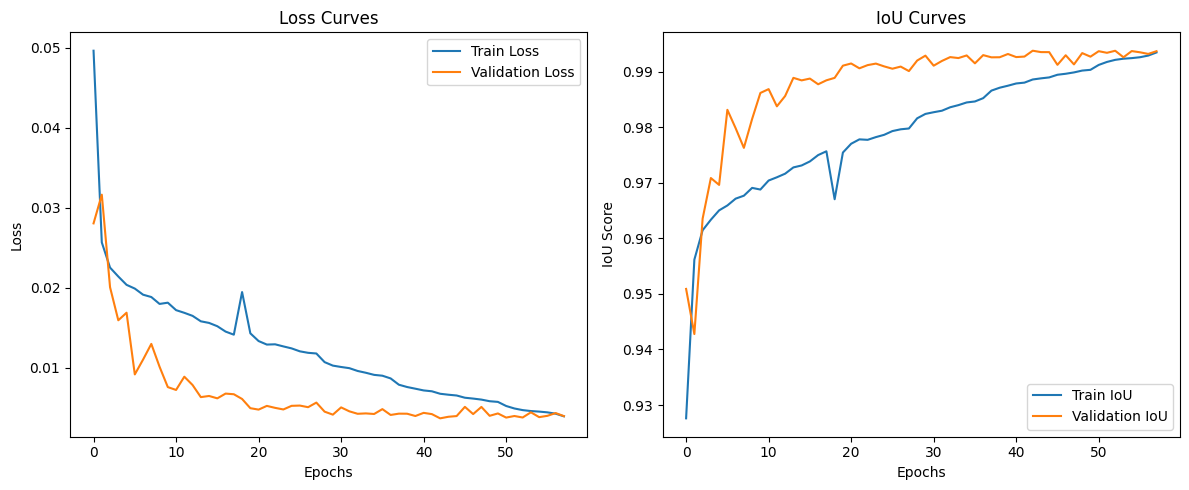

1/1 [==============================] - 0s 58ms/step


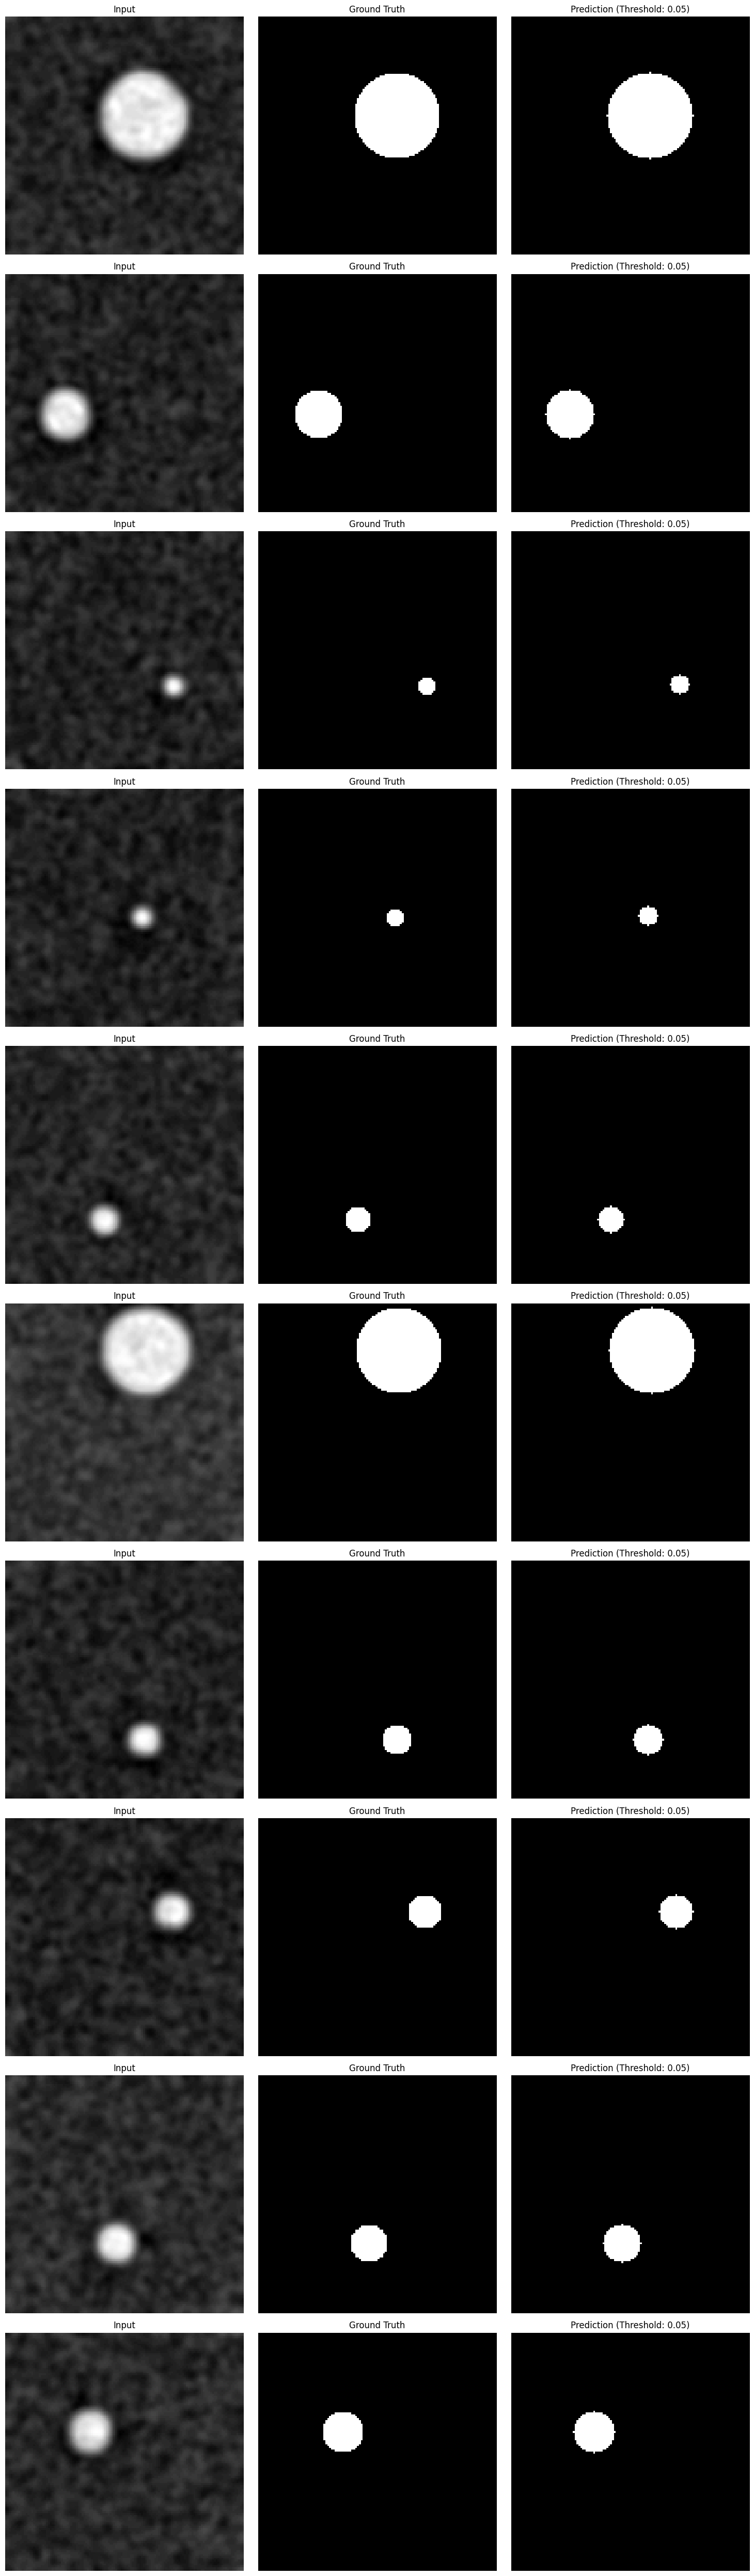

1/1 [==============================] - 0s 59ms/step


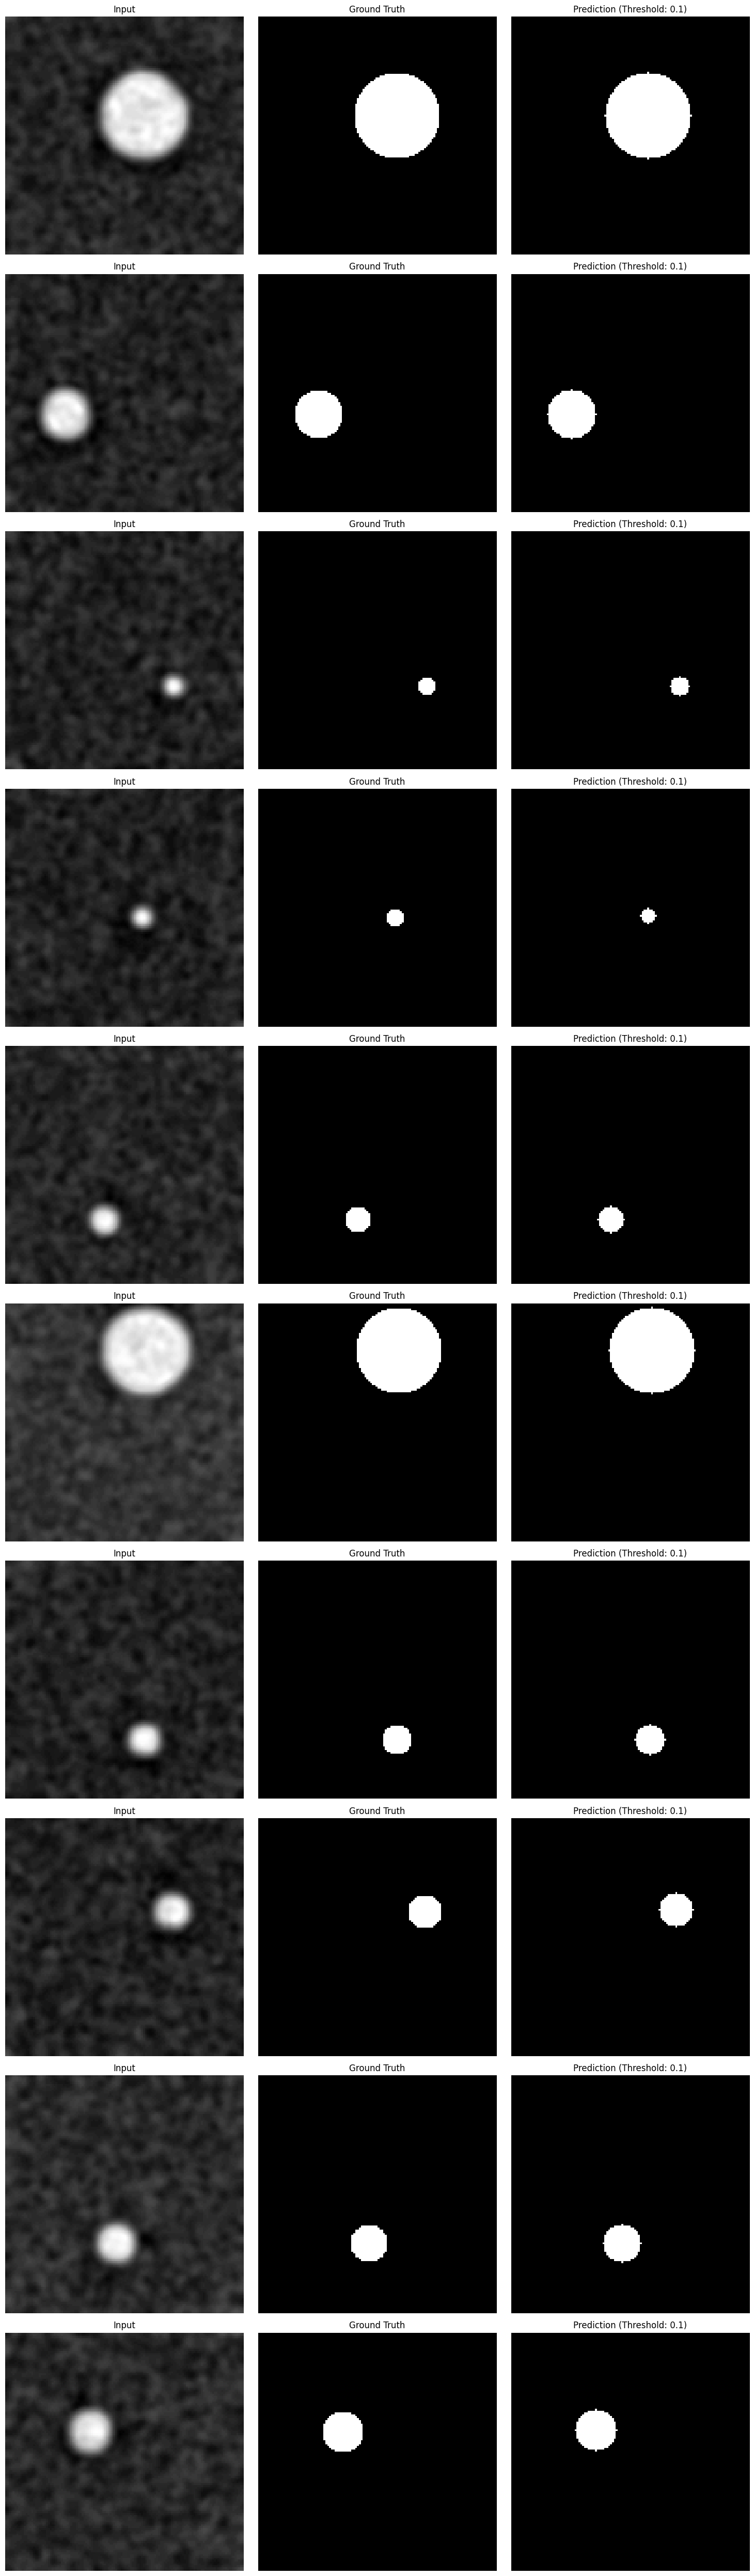

1/1 [==============================] - 0s 52ms/step


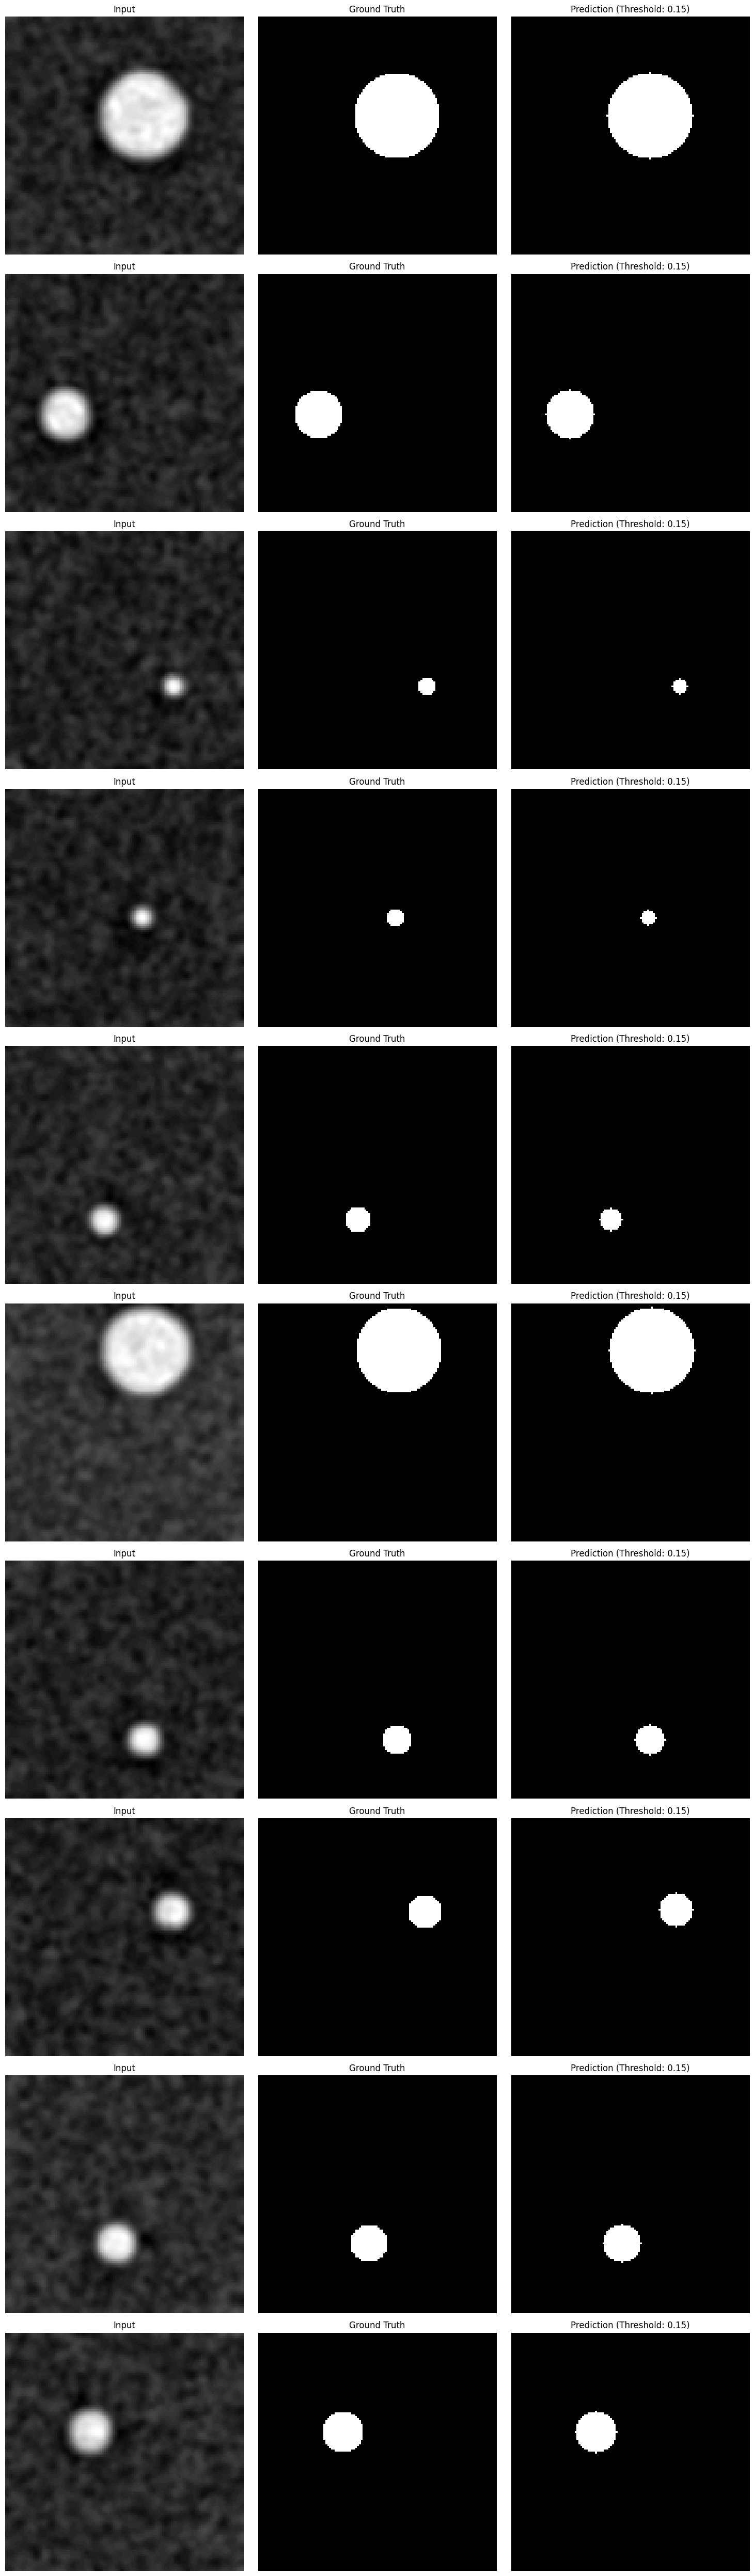

1/1 [==============================] - 0s 56ms/step


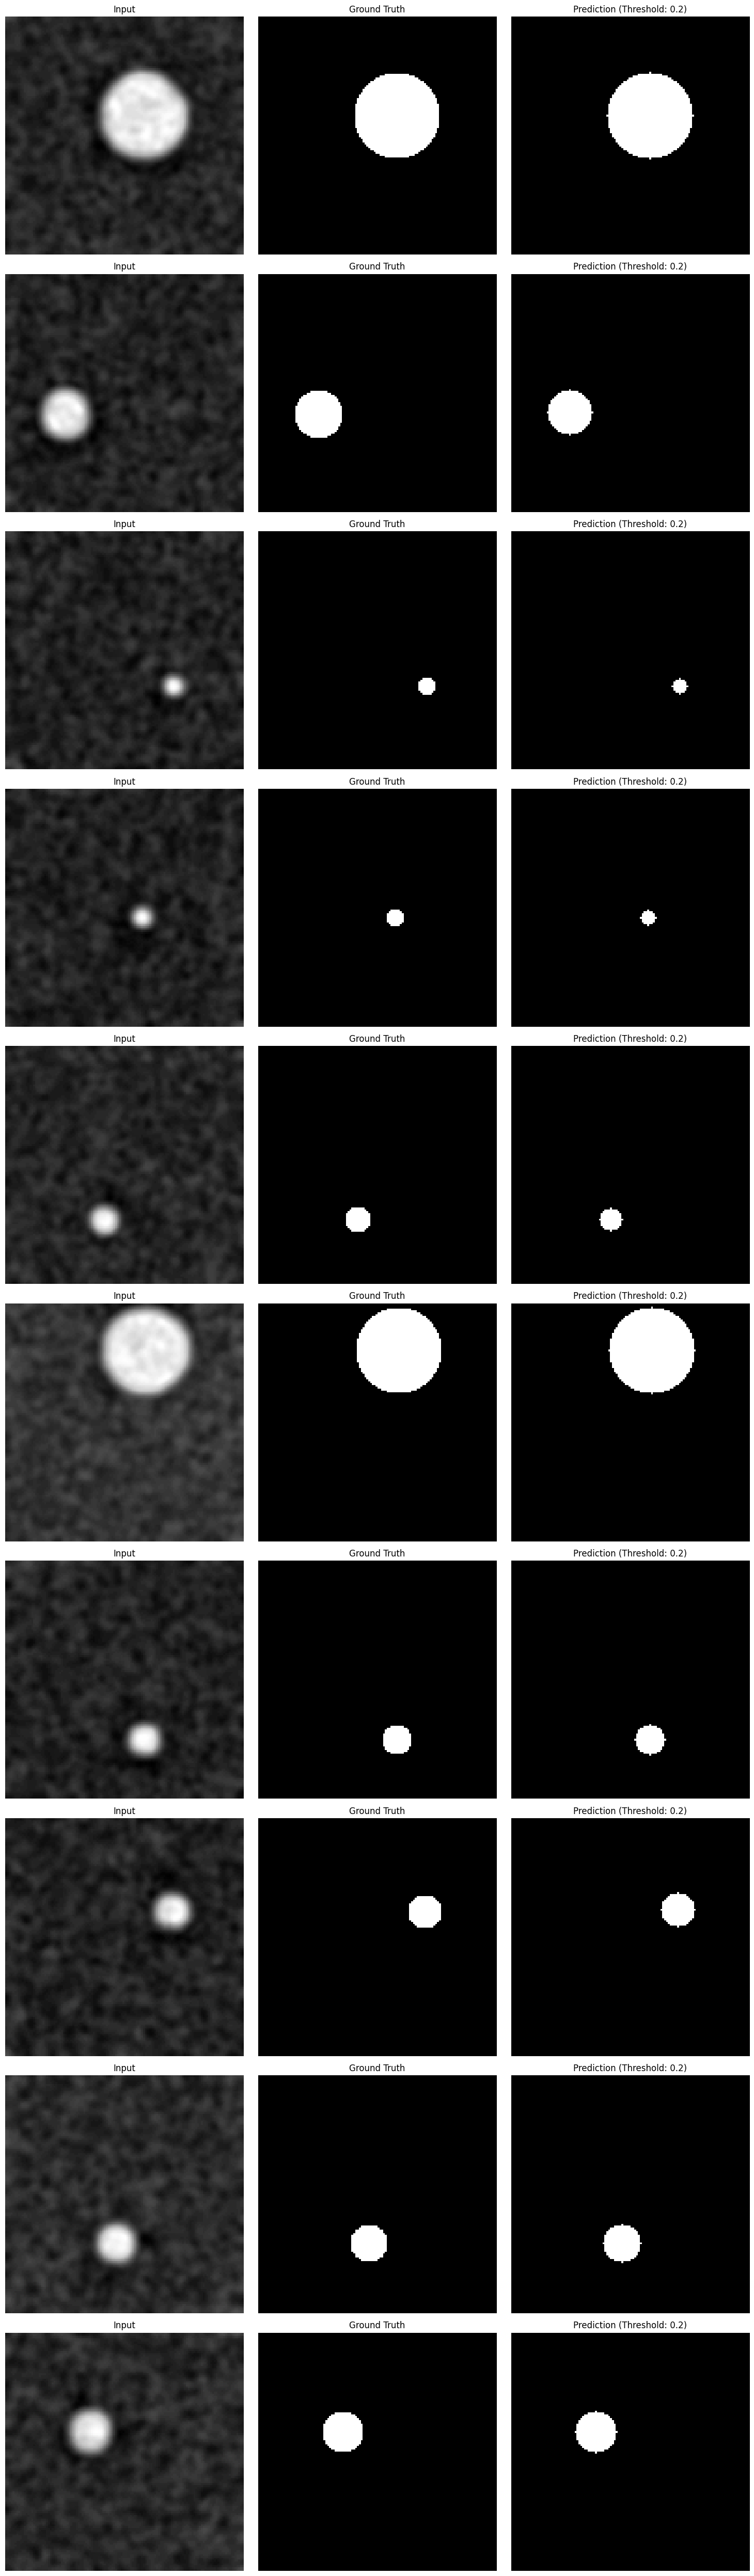

1/1 [==============================] - 0s 55ms/step


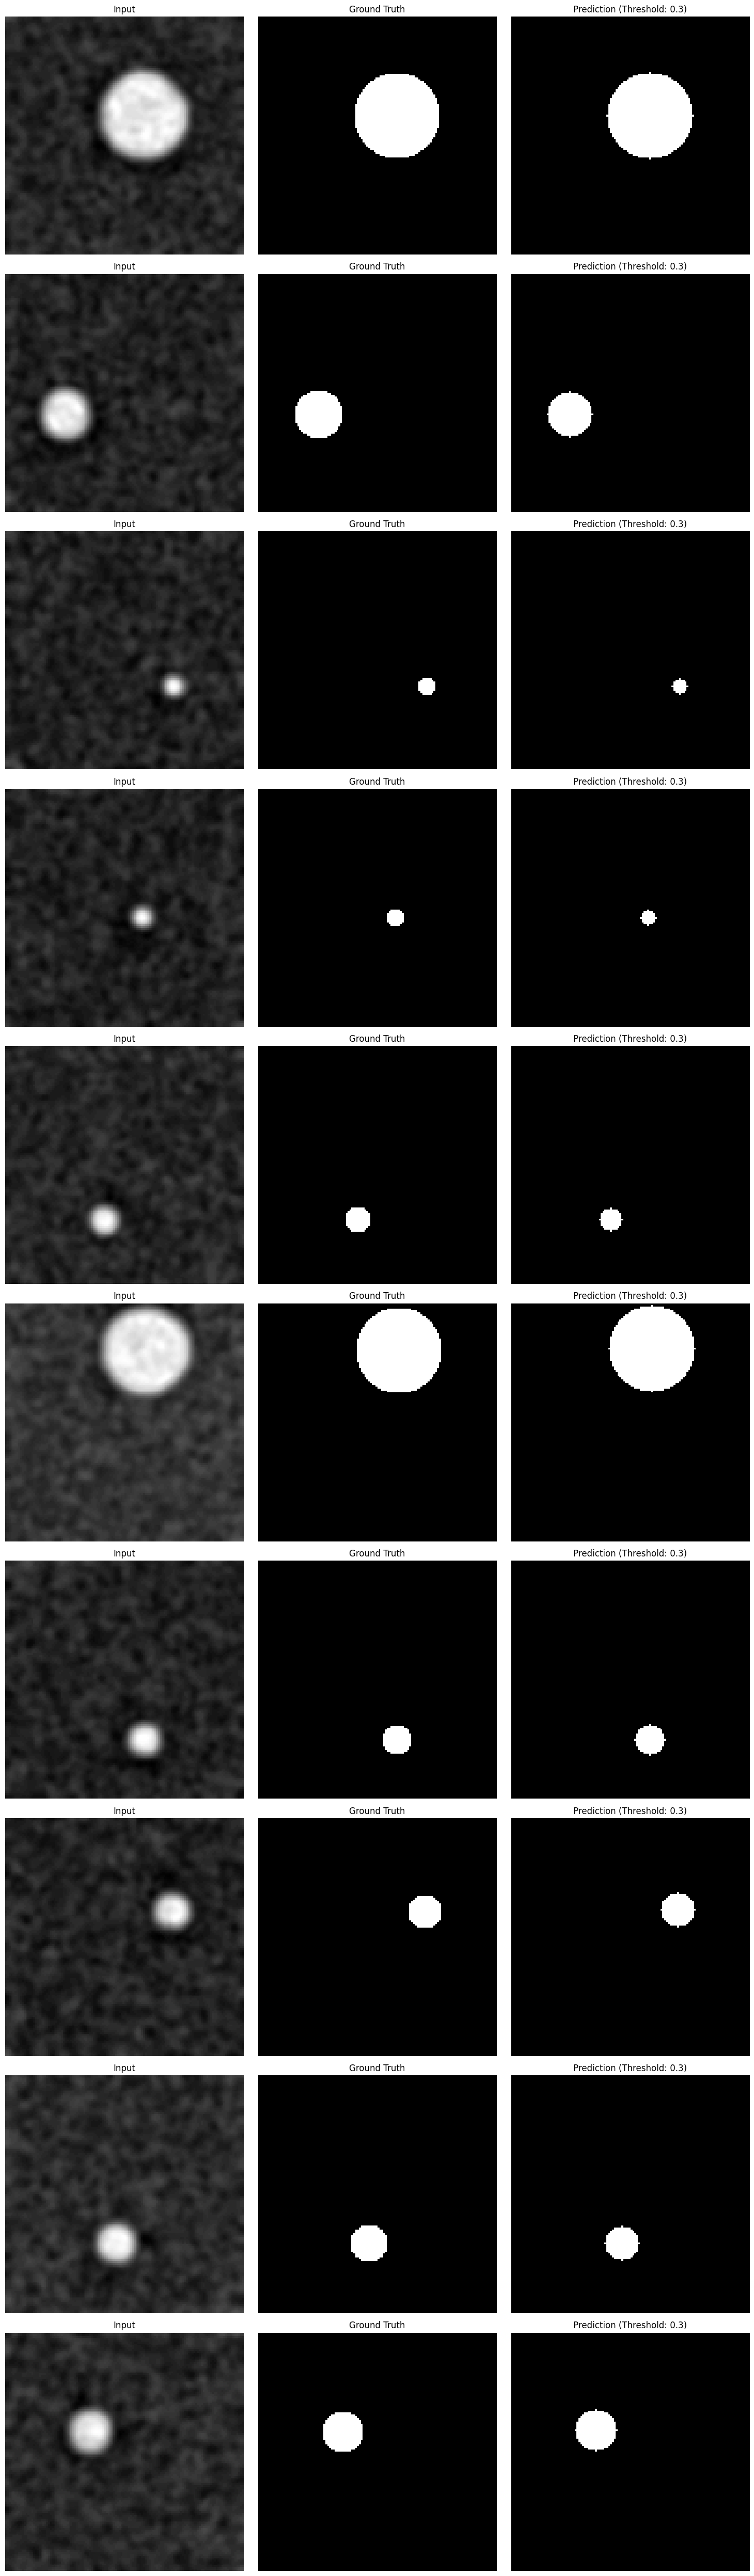

16/16 [==============================] - 1s 40ms/step
임계값 0.15에서의 결과:
IoU 점수: 0.8795
픽셀 정확도: 0.9978


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, BatchNormalization, Activation, Add, Multiply, Concatenate
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, map_coordinates
import os

# ✅ TensorFlow GPU 활성화 (변경 없음)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ GPU 활성화 완료!")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ GPU를 사용할 수 없습니다. CPU 모드로 실행됩니다.")

# ✅ 학습 결과 저장 디렉토리 생성 (변경 없음)
if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')

# ✅ 시각화 결과 저장 디렉토리 추가
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# ✅ 코드 맨 앞에 추가 (변경 없음)
tf.config.run_functions_eagerly(True)

# ====================================================================================
# ✅✅✅ 1. 손실 함수 단순화 - 복잡한 손실 함수들 대신 단순하고 효과적인 손실 함수 사용
# ====================================================================================

def iou_score(y_true, y_pred, smooth=1e-6):
    """IoU 점수 계산 함수 (변경 없음)"""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    """Dice Loss (변경 없음)"""
    return 1.0 - iou_score(y_true, y_pred, smooth)

# ✅ 단순화된 손실 함수 - 원래 복잡한 손실 함수 대신 사용
def simplified_loss(y_true, y_pred):
    """단순화된 손실 함수 - 원 검출에 최적화"""
    # Dice Loss (형태 보존에 좋음)
    dice = dice_loss(y_true, y_pred)
    
    # 기본 Binary Cross Entropy
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    
    # 양성 픽셀에 더 높은 가중치 (원에 집중)
    pos_weight = 5.0  # 원래보다 더 높은 가중치
    weight_vector = y_true * pos_weight + (1. - y_true)
    weighted_bce = K.mean(weight_vector * K.binary_crossentropy(y_true, y_pred))
    
    # 단순하지만 효과적인 가중치 조합
    return 0.5 * dice + 0.3 * bce + 0.2 * weighted_bce

# ====================================================================================
# ✅✅✅ 2. 데이터 생성 개선 - 대비가 높은 훈련 데이터 생성
# ====================================================================================

def generate_higher_contrast_data(num_samples=5000, img_size=128):
    """대비가 향상된 데이터 생성 함수"""
    # 더 어두운 배경(0.1~0.3)에 더 밝은 원(0.7~1.0) 생성
    X = np.random.rand(num_samples, img_size, img_size, 1) * 0.2 + 0.1  # 어두운 배경
    Y = np.zeros((num_samples, img_size, img_size, 1), dtype=np.float32)

    for i in range(num_samples):
        # 위치 설정 (가장자리에서 충분한 여백)
        margin = int(img_size * 0.2)
        x_center = np.random.randint(margin, img_size-margin)
        y_center = np.random.randint(margin, img_size-margin)
        
        # 작은 원과 중간 크기 원 생성
        is_small = np.random.random() < 0.7  # 70%는 작은 원
        if is_small:
            radius = np.random.randint(5, 12)
        else:
            radius = np.random.randint(12, 25)
        
        # 원 생성 - 여기서 중요한 변경: 입력 이미지에도 원을 그려줌(대비 향상)
        for x in range(img_size):
            for y in range(img_size):
                if (x - x_center)**2 + (y - y_center)**2 < radius**2:
                    # 입력 이미지에 밝은 원 추가 (중요: 대비 증가)
                    X[i, x, y, 0] = np.random.uniform(0.7, 1.0)  # 밝은 원
                    Y[i, x, y, 0] = 1
    
    return X, Y

# ✅ 전처리 함수 단순화 - 노이즈 감소와 대비 향상에 집중
def preprocess_input(X, denoise_strength=2.0):  # 노이즈 감소 강도 증가
    """향상된 전처리 함수"""
    X_processed = []
    
    for img in X:
        # 가우시안 블러로 노이즈 감소 (강도 증가)
        denoised = gaussian_filter(img.squeeze(), sigma=denoise_strength)
        
        # CLAHE 적용 (대비 향상) - 파라미터 조정
        denoised_uint8 = (denoised * 255).astype(np.uint8)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))  # clipLimit 증가
        enhanced = clahe.apply(denoised_uint8)
        
        # 정규화
        normalized = enhanced.astype(np.float32) / 255.0
        
        X_processed.append(normalized)
    
    return np.expand_dims(np.array(X_processed), axis=-1)

# ✅ 데이터 증강 함수 단순화 - 핵심 변환만 유지
def augment_image(image, mask):
    """단순화된 데이터 증강 함수"""
    # 좌우반전
    if np.random.rand() > 0.5:
        image, mask = np.fliplr(image), np.fliplr(mask)

    # 회전 변형 (-25도 ~ 25도)
    if np.random.rand() > 0.5:
        angle = np.random.uniform(-25, 25)
        M = cv2.getRotationMatrix2D((image.shape[1] // 2, image.shape[0] // 2), angle, 1)
        image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
        mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_NEAREST)

    # 밝기 조정
    if np.random.rand() > 0.5:
        brightness = np.random.uniform(0.7, 1.3)
        image = image * brightness
        image = np.clip(image, 0, 1)
    
    return image, mask

# ====================================================================================
# ✅✅✅ 3. 모델 아키텍처 단순화 - 더 단순하고 안정적인 U-Net 모델
# ====================================================================================

# ✅ 컨볼루션 블록 함수 - 단순화
def conv_block(inputs, filters, dropout_rate=0.0, use_residual=True):
    """단순화된 컨볼루션 블록"""
    x = layers.Conv2D(filters, (3, 3), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
        
    x = layers.Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if use_residual:
        res = layers.Conv2D(filters, (1, 1), padding="same")(inputs)
        x = Add()([x, res])
        
    return x

# ✅ 단순화된 U-Net 모델 - 어텐션 메커니즘 제거, 필터 수 감소
def simple_unet_model(input_shape=(128, 128, 1)):
    """단순화된 U-Net 모델"""
    inputs = Input(input_shape)
    
    # 인코더 경로 - 필터 수 감소 (복잡도 감소)
    # Level 1
    conv1 = conv_block(inputs, 32, dropout_rate=0.1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    # Level 2
    conv2 = conv_block(pool1, 64, dropout_rate=0.1)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    # Level 3
    conv3 = conv_block(pool2, 128, dropout_rate=0.2)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)

    # Level 4
    conv4 = conv_block(pool3, 256, dropout_rate=0.2)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)

    # Bridge
    bridge = conv_block(pool4, 512, dropout_rate=0.3, use_residual=True)

    # 디코더 경로 - 단순한 스킵 연결 사용
    # Level 4
    up4 = layers.UpSampling2D((2, 2))(bridge)
    concat4 = Concatenate()([up4, conv4])
    conv5 = conv_block(concat4, 256, dropout_rate=0.2)

    # Level 3
    up3 = layers.UpSampling2D((2, 2))(conv5)
    concat3 = Concatenate()([up3, conv3])
    conv6 = conv_block(concat3, 128, dropout_rate=0.2)

    # Level 2
    up2 = layers.UpSampling2D((2, 2))(conv6)
    concat2 = Concatenate()([up2, conv2])
    conv7 = conv_block(concat2, 64, dropout_rate=0.1)

    # Level 1
    up1 = layers.UpSampling2D((2, 2))(conv7)
    concat1 = Concatenate()([up1, conv1])
    conv8 = conv_block(concat1, 32, dropout_rate=0.1)

    # 출력 레이어 - 시그모이드 활성화
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv8)

    model = Model(inputs, outputs)
    return model

# ====================================================================================
# ✅✅✅ 4. 학습 파라미터 및 콜백 조정
# ====================================================================================

# ✅ 학습 중 예측 시각화 콜백 - 중간 결과 확인을 위한 필수 도구
class VisualizePredictions(tf.keras.callbacks.Callback):
    """학습 중 예측 결과를 시각화하는 콜백"""
    def __init__(self, test_data, test_labels, num_samples=3, threshold=0.3):
        self.test_data = test_data[:num_samples]
        self.test_labels = test_labels[:num_samples]
        self.num_samples = num_samples
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # 5 에폭마다 시각화
            predictions = self.model.predict(self.test_data)
            binary_preds = (predictions > self.threshold).astype(np.float32)
            
            fig, axes = plt.subplots(self.num_samples, 3, figsize=(15, 5*self.num_samples))
            for i in range(self.num_samples):
                axes[i, 0].imshow(self.test_data[i].squeeze(), cmap="gray")
                axes[i, 0].set_title("Input")
                axes[i, 1].imshow(self.test_labels[i].squeeze(), cmap="gray")
                axes[i, 1].set_title("Ground Truth")
                axes[i, 2].imshow(binary_preds[i].squeeze(), cmap="gray")
                axes[i, 2].set_title(f"Prediction (Threshold: {self.threshold})")
            
            plt.tight_layout()
            plt.savefig(f'visualizations/pred_epoch_{epoch}.png')
            plt.close()

# ✅ 학습 설정 함수 개선 - 학습률 증가, 콜백 추가
def setup_training(threshold=0.3):
    """개선된 학습 설정"""
    # 조기 종료 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )

    # 학습률 감소 스케줄러
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.7,  # 더 완만한 감소
        patience=7,
        verbose=1,
        min_lr=1e-6
    )

    # 체크포인트
    checkpoint = ModelCheckpoint(
        'checkpoints/model.{epoch:02d}-{val_loss:.4f}.h5',
        monitor='val_loss',
        save_best_only=True
    )

    # 학습률 증가 (5e-5에서 5e-4로 10배 증가)
    optimizer = Adam(learning_rate=5e-4)
    
    return early_stopping, lr_scheduler, checkpoint, optimizer, threshold

# ====================================================================================
# ✅✅✅ 5. 앙상블 예측 및 후처리 개선
# ====================================================================================

# ✅ 앙상블 예측 함수 수정 - 임계값 대폭 낮춤
def ensemble_prediction(model, X, threshold=0.15):  # 임계값 대폭 낮춤 (0.3 → 0.15)
    """앙상블 예측 함수 - 임계값 낮추고 후처리 강화"""
    # 원본 입력에 대한 예측
    pred_original = model.predict(X)
    predictions = [pred_original]
    
    # 다양한 데이터 증강 적용 (간소화)
    for i in range(5):  # 앙상블 크기 감소 (10 → 5)
        X_aug = []
        aug_transformations = []
        
        for img in X:
            img_squeezed = img.squeeze()
            
            if i % 4 == 0:  # 회전
                angle = np.random.uniform(-15, 15)
                M = cv2.getRotationMatrix2D((img_squeezed.shape[1] // 2, img_squeezed.shape[0] // 2), angle, 1)
                img_aug = cv2.warpAffine(img_squeezed, M, (img_squeezed.shape[1], img_squeezed.shape[0]))
                aug_transformations.append(('rotation', angle))
            elif i % 4 == 1:  # 좌우 반전
                img_aug = np.fliplr(img_squeezed)
                aug_transformations.append(('horizontal_flip', None))
            elif i % 4 == 2:  # 상하 반전
                img_aug = np.flipud(img_squeezed)
                aug_transformations.append(('vertical_flip', None))
            else:  # 밝기 조정
                brightness = np.random.uniform(0.8, 1.2)
                img_aug = np.clip(img_squeezed * brightness, 0, 1)
                aug_transformations.append(('brightness', brightness))
                
            img_aug = np.expand_dims(img_aug, axis=-1)
            X_aug.append(img_aug)
        
        X_aug = np.array(X_aug)
        
        # 증강된 이미지에 대한 예측
        pred_aug = model.predict(X_aug)
        
        # 변환 역적용
        for j, (aug_type, param) in enumerate(aug_transformations):
            pred_j = pred_aug[j].squeeze()
            
            if aug_type == 'rotation':
                angle = -param
                M = cv2.getRotationMatrix2D((pred_j.shape[1] // 2, pred_j.shape[0] // 2), angle, 1)
                pred_j = cv2.warpAffine(pred_j, M, (pred_j.shape[1], pred_j.shape[0]))
            elif aug_type == 'horizontal_flip':
                pred_j = np.fliplr(pred_j)
            elif aug_type == 'vertical_flip':
                pred_j = np.flipud(pred_j)
            
            pred_aug[j] = np.expand_dims(pred_j, axis=-1)
        
        predictions.append(pred_aug)
    
    # 모든 예측의 평균 계산
    avg_pred = np.mean(predictions, axis=0)
    
    # 후처리 적용
    post_processed = np.array([aggressive_post_process(pred.squeeze(), threshold=threshold) for pred in avg_pred])
    
    return post_processed

# ✅ 적극적인 후처리 함수 - 극도로 낮은 임계값과 원 피팅
def aggressive_post_process(mask, threshold=0.15, min_area=3):
    """적극적인 후처리 함수"""
    # 매우 낮은 임계값 적용
    binary_mask = (mask > threshold).astype(np.uint8)
    
    # 노이즈 제거 및 구멍 채우기
    kernel = np.ones((3, 3), np.uint8)
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    
    # 윤곽선 찾기
    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 결과 마스크 초기화
    final_mask = np.zeros_like(binary_mask)
    
    if contours:
        # 면적이 일정 이상인 모든 윤곽선 처리
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > min_area:  # 매우 작은 영역도 포함
                # 원 피팅 (타원을 원으로 변환)
                (x, y), radius = cv2.minEnclosingCircle(contour)
                center = (int(x), int(y))
                radius = int(radius)
                
                # 최종 마스크에 원 그리기
                cv2.circle(final_mask, center, radius, 1, -1)
    else:
        # 윤곽선이 없는 경우 원본 이진화 마스크 그대로 사용
        if np.sum(binary_mask) > 3:  # 최소 3픽셀 이상이면 유지
            final_mask = binary_mask
    
    return final_mask

# ====================================================================================
# ✅✅✅ 6. 메인 훈련 함수
# ====================================================================================

def training_setup():
    """메인 훈련 함수"""
    # 향상된 데이터 생성
    X_train, Y_train = generate_higher_contrast_data(num_samples=5000)  # 샘플 수 증가
    X_test, Y_test = generate_higher_contrast_data(num_samples=500)
    
    # 입력 데이터 전처리
    X_train_processed = preprocess_input(X_train, denoise_strength=2.0)  # 노이즈 제거 강도 증가
    X_test_processed = preprocess_input(X_test, denoise_strength=2.0)
    
    # 데이터 증강 적용
    X_train_aug, Y_train_aug = [], []
    for i in range(len(X_train_processed)):
        img, mask = augment_image(X_train_processed[i], Y_train[i])
        X_train_aug.append(img)
        Y_train_aug.append(mask)
    
    # 데이터 변환
    X_train_aug = np.array([img if len(img.shape) == 3 else np.expand_dims(img, axis=-1) for img in X_train_aug])
    Y_train_aug = np.array([mask if len(mask.shape) == 3 else np.expand_dims(mask, axis=-1) for mask in Y_train_aug])
    
    # 훈련 전 데이터 시각화
    visualize_training_data(X_train_aug, Y_train_aug, num_samples=5)
    
    # 모델 생성 - 단순화된 U-Net 사용
    unet = simple_unet_model()
    
    # 낮은 임계값 설정
    threshold = 0.15
    
    # 훈련 설정
    early_stopping, lr_scheduler, checkpoint, optimizer, _ = setup_training(threshold)
    
    # 시각화 콜백 추가
    visualize_callback = VisualizePredictions(X_test_processed, Y_test, threshold=threshold)
    
    # 모델 컴파일
    unet.compile(
        optimizer=optimizer, 
        loss=simplified_loss,  # 단순화된 손실 함수 사용
        metrics=[iou_score, "accuracy"]
    )
    
    # 모델 구조 요약
    unet.summary()
    
    # 학습 실행
    history = unet.fit(
        X_train_aug, Y_train_aug,
        epochs=100,  # 에폭 수 증가
        batch_size=8,  # 배치 크기 감소
        validation_data=(X_test_processed, Y_test),
        callbacks=[
            early_stopping,
            lr_scheduler,
            checkpoint,
            visualize_callback  # 시각화 콜백 추가
        ],
        verbose=1,
        shuffle=True
    )
    
    # 학습 과정 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['iou_score'], label='Train IoU')
    plt.plot(history.history['val_iou_score'], label='Validation IoU')
    plt.title('IoU Curves')
    plt.xlabel('Epochs')
    plt.ylabel('IoU Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('visualizations/training_curves.png')
    plt.show()
    
    # 테스트 평가 (낮은 임계값 사용)
    predict_and_visualize(unet, X_test_processed, Y_test, num_samples=10)
    evaluate_model(unet, X_test_processed, Y_test, threshold=threshold)
    
    return unet, history

# ✅ 데이터 시각화 함수 추가
def visualize_training_data(X, Y, num_samples=5):
    """훈련 데이터 시각화 함수"""
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))
    for i in range(num_samples):
        # 입력 이미지
        axes[i, 0].imshow(X[i].squeeze(), cmap="gray")
        axes[i, 0].set_title("Input")
        axes[i, 0].axis('off')
        
        # 실제 마스크
        axes[i, 1].imshow(Y[i].squeeze(), cmap="gray")
        axes[i, 1].set_title("Ground Truth")
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.savefig('visualizations/training_data_check.png')
    plt.show()

# ✅ 예측 및 시각화 함수 개선
def predict_and_visualize(model, X, Y, num_samples=5):
    """예측 및 시각화 함수 - 다양한 임계값 테스트"""
    # 다양한 임계값으로 예측
    thresholds = [0.05, 0.1, 0.15, 0.2, 0.3]
    
    for threshold in thresholds:
        predictions = ensemble_prediction(model, X[:num_samples], threshold=threshold)
        
        # 시각화
        fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
        
        for i in range(num_samples):
            # 입력 이미지
            axes[i, 0].imshow(X[i].squeeze(), cmap="gray")
            axes[i, 0].set_title("Input")
            axes[i, 0].axis('off')
            
            # 실제 마스크
            axes[i, 1].imshow(Y[i].squeeze(), cmap="gray")
            axes[i, 1].set_title("Ground Truth")
            axes[i, 1].axis('off')
            
            # 예측 마스크
            axes[i, 2].imshow(predictions[i], cmap="gray")
            axes[i, 2].set_title(f"Prediction (Threshold: {threshold})")
            axes[i, 2].axis('off')
        
        plt.tight_layout()
        plt.savefig(f'visualizations/predictions_threshold_{threshold}.png')
        plt.show()

# ✅ 모델 평가 함수 개선
def evaluate_model(model, X, Y, threshold=0.15):
    """모델 평가 함수 - 매우 낮은 임계값 사용"""
    # 앙상블 예측 방식 사용
    binary_preds = ensemble_prediction(model, X, threshold=threshold)
    
    # IoU 계산
    ious = []
    pixel_accuracies = []
    
    for i in range(len(binary_preds)):
        true = Y[i].squeeze()
        pred = binary_preds[i].squeeze()
        
        intersection = np.logical_and(true, pred).sum()
        union = np.logical_or(true, pred).sum()
        
        if union == 0:  # 예외 처리
            iou = 0
        else:
            iou = intersection / union
            
        ious.append(iou)
        
        # 픽셀별 정확도
        pixel_accuracy = np.mean((pred == true).astype(np.float32))
        pixel_accuracies.append(pixel_accuracy)
    
    mean_iou = np.mean(ious)
    mean_pixel_accuracy = np.mean(pixel_accuracies)
    
    print(f"임계값 {threshold}에서의 결과:")
    print(f"IoU 점수: {mean_iou:.4f}")
    print(f"픽셀 정확도: {mean_pixel_accuracy:.4f}")
    
    return mean_pixel_accuracy, mean_iou

model, history = training_setup()

In [1]:
# 모델 저장하기 - SavedModel 형식
def save_model(model, save_path='saved_models'):
    """학습된 모델을 SavedModel 및 H5 형식으로 저장합니다."""
    import os
    from datetime import datetime
    
    # 저장 디렉토리 생성
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # 현재 시간으로 모델 이름 생성
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_name = f"circle_detection_model_{timestamp}"
    
    # SavedModel 형식으로 저장 (TensorFlow 기본 형식)
    model_path = os.path.join(save_path, model_name)
    model.save(model_path)
    print(f"모델이 SavedModel 형식으로 저장되었습니다: {model_path}")
    
    # H5 형식으로도 저장 (더 간편한 로딩)
    h5_path = os.path.join(save_path, f"{model_name}.h5")
    model.save(h5_path)
    print(f"모델이 H5 형식으로도 저장되었습니다: {h5_path}")
    
    return model_path, h5_path

# 전이학습을 위해 모델 추출하기
def extract_model_for_transfer_learning(model, layer_name=None):
    """전이학습을 위해 모델의 일부를 추출합니다."""
    if layer_name:
        # 특정 레이어까지의 모델 추출
        from tensorflow.keras import Model
        extracted_model = Model(
            inputs=model.input,
            outputs=model.get_layer(layer_name).output
        )
        print(f"레이어 '{layer_name}'까지의 모델이 추출되었습니다.")
    else:
        # 전체 모델 사용
        extracted_model = model
        print("전체 모델이 추출되었습니다.")
    
    return extracted_model

# 모델 로드하기
def load_saved_model(model_path):
    """저장된 모델을 로드합니다."""
    import tensorflow as tf
    
    try:
        # SavedModel 또는 H5 형식 감지
        if model_path.endswith('.h5'):
            loaded_model = tf.keras.models.load_model(
                model_path,
                custom_objects={
                    'iou_score': iou_score,
                    'dice_loss': dice_loss,
                    'simplified_loss': simplified_loss
                }
            )
            print(f"H5 모델을 로드했습니다: {model_path}")
        else:
            loaded_model = tf.keras.models.load_model(
                model_path,
                custom_objects={
                    'iou_score': iou_score,
                    'dice_loss': dice_loss,
                    'simplified_loss': simplified_loss
                }
            )
            print(f"SavedModel을 로드했습니다: {model_path}")
        
        return loaded_model
    
    except Exception as e:
        print(f"모델 로드 중 오류 발생: {e}")
        return None

# 메인 함수로 호출하면:
def extract_and_save_model(trained_model):
    """학습된 모델을 저장하고 추출합니다."""
    # 1. 전체 모델 저장
    model_path, h5_path = save_model(trained_model)
    
    # 2. 모델 로드 테스트
    loaded_model = load_saved_model(h5_path)
    
    if loaded_model:
        print("모델이 성공적으로 로드되었습니다!")
        # 모델 구조 출력
        loaded_model.summary()
    
    return model_path, h5_path

# training_setup() 함수 후에 추가:
model_path, h5_path = extract_and_save_model(model)
print(f"모델 추출 완료! 저장 경로: {model_path}")

NameError: name 'model' is not defined